# House Prices - Regression Predictions YData 2024    

**Team: Random Forest Rangers** ([Dmitry Gufranov](https://www.linkedin.com/in/gufranov/), [Evgenia Amineva](https://www.linkedin.com/in/janeami/), [Valeriya Vazhnova](https://www.linkedin.com/in/gufranov/))

### Import libraries

In [26]:
import pandas as pd 
import numpy as np 
import datetime

# vizualisation
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# ml
from lightgbm import LGBMRegressor
import catboost as cb
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoCV, Ridge, RidgeCV, LinearRegression
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR

from mlxtend.regressor import StackingCVRegressor
from sklearn.pipeline import make_pipeline
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler,  RobustScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

In [27]:
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter('ignore')

### Loading the data

In [28]:
# load the train data
df = pd.read_csv('train.csv')
display(df.head(3))

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [29]:
df_test = pd.read_csv('test.csv')
display(df_test.head(3))

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal


### Preprocessing

In [30]:
from sklearn.base import BaseEstimator, TransformerMixin

class FillMissTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        df_upd = X.copy()

        if 'LotFrontage' in df_upd.columns:
            self.nb_lot = df_upd.groupby('Neighborhood')['LotFrontage'].mean()
        
        return self
    
    def fill_lot(self, x):
        if pd.notnull(x['LotFrontage']):
            return x['LotFrontage']
        else:
            return self.nb_lot.loc[x['Neighborhood']]

    def transform(self, X):
        df_upd = X.copy()

        # Fill columns where missing values have a meaning 'NA'
        feat_wn = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType', 'FireplaceQu',
           'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtFinType2', 'BsmtExposure',
           'BsmtFinType1', 'BsmtCond', 'BsmtQual']
        
        for c in feat_wn:
            df_upd[c].fillna('NA', inplace=True)

        # Fill columns where missing values have a meaning '0'
        feat_w0 = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath',
           'BsmtHalfBath', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'MasVnrArea']   #'GarageYrBlt'

        for c in feat_w0:
            df_upd[c].fillna(0, inplace=True)

        # Fill 'LotFrontage' with mean values grouped by 'Neighborhood'
        if 'LotFrontage' in df_upd.columns:
            df_upd['LotFrontage'] = df_upd.apply(self.fill_lot, axis=1)
            # df_upd['LotFrontage'] = df_upd.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.mean()))
   

        # Fill missing numeric features with mean values
        num_si = SimpleImputer(strategy='mean')
        num_col = df_upd.select_dtypes(include=['int', 'float']).columns
        df_upd[num_col] = num_si.fit_transform(df_upd[num_col])

        # Fill missing categorical features with most frequent values
        cat_si = SimpleImputer(strategy='most_frequent')
        cat_col = df_upd.select_dtypes(include=['object']).columns
        df_upd[cat_col] = cat_si.fit_transform(df_upd[cat_col])

        return df_upd

In [31]:
class FeatureEngineeringTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, num_cols_tdrop, num_cols_flag, rem_id):
        self.num_cols_tdrop = num_cols_tdrop
        self.num_cols_flag = num_cols_flag
        self.rem_id = rem_id
    
    def fit(self, X, y=None):
        # No need to fit anything for this transformer
        df_upd = X.copy()

        if 'OverallQual' in df_upd.columns and 'Neighborhood' in df_upd.columns:
            self.nb_qual = df_upd.groupby('Neighborhood')['OverallQual'].mean()

        return self
    
    def fill_nbgh(self, x):
        return self.nb_qual.loc[x['Neighborhood']]

    def transform(self, X):
        df_upd = X.copy()

        #Remove outliers
        # df_upd = df_upd[~df_upd['Id'].isin(self.rem_id)]

        # Create new feature for bathrooms
        #df_upd['Bath'] = 0.225 * df_upd['BsmtFullBath'] + (-0.0121) * df_upd['BsmtHalfBath'] + 0.636 * df_upd['FullBath'] + 0.343 * df_upd['HalfBath']
        df_upd['Totalarea'] = df_upd['GrLivArea'] + df_upd['LotArea']
        #df_upd['Neighborhoodqual'] = df_upd.groupby('Neighborhood')['OverallQual'].transform('mean')
        df_upd['Neighborhoodqual'] = df_upd.apply(self.fill_nbgh, axis=1)

        df_upd['SqFtPerRoom'] = df_upd["GrLivArea"] / (df_upd["TotRmsAbvGrd"] +
                                                       df_upd["FullBath"] +
                                                       df_upd["HalfBath"] +
                                                       df_upd["KitchenAbvGr"])

        df_upd['Total_Home_Quality'] = df_upd['OverallQual'] + df_upd['OverallCond']

        # df_upd['Total_Bathrooms'] = (df_upd['FullBath'] + (0.5 * df_upd['HalfBath']) +
        #                        df_upd['BsmtFullBath'] + (0.5 * df_upd['BsmtHalfBath']))

        df_upd['HighQualSF'] = df_upd['1stFlrSF'] + df_upd['2ndFlrSF']

        # Drop columns
        df_upd = df_upd.drop(self.num_cols_tdrop, axis=1)

        # Flag transformation for numeric columns
        for c in self.num_cols_flag:
            if c in df_upd.columns:
                df_upd[c] = df_upd[c].apply(lambda x: 1 if x > 0 else 0)

        return df_upd

In [32]:
class CategoricalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, cat_cols_oh, cat_cols_oe, cat_cols_tdrop):
        self.cat_cols_oh = cat_cols_oh
        self.cat_cols_oe = cat_cols_oe
        self.cat_cols_tdrop = cat_cols_tdrop
    
    def fit(self, X, y=None):
        # No need to fit anything for this transformer
        return self
    
    def transform(self, X):
        df_upd = X.copy()

        # Merge values in Neighborhood
        if 'Neighborhood' in df_upd.columns:            
            df_upd['Neighborhood'] = df_upd['Neighborhood'].apply(lambda x: 'MostExp' if x in ['NoRidge', 'NridgHt', 'StoneBr'] else x)
            df_upd['Neighborhood'] = df_upd['Neighborhood'].apply(lambda x: 'MostChp' if x in ['MeadowV', 'IDOTRR', 'BrDale', 'Edwards', \
                                                                                               'BrkSide', 'OldTown', 'Sawyer', 'Blueste', \
                                                                                                'SWISU', 'NPkVill', 'Mitchel', 'NAmes'] else x)
            df_upd['Neighborhood'] = df_upd['Neighborhood'].apply(lambda x: 'Chp' if x in ['SawyerW', 'NWAmes', 'Gilbert', 'Blmngtn'] else x)
            df_upd['Neighborhood'] = df_upd['Neighborhood'].apply(lambda x: 'Exp' if x in ['Somerst', 'Veenker', 'Timber'] else x)
            df_upd['Neighborhood'] = df_upd['Neighborhood'].apply(lambda x: 'Mid' if x in ['CollgCr', 'Crawfor', 'ClearCr'] else x)

        # Merge values in LotConfig
        if 'LotConfig' in df_upd.columns:
            df_upd.loc[df_upd['LotConfig']=='FR3', 'LotConfig'] = 'FR2'

        # Merge values in LotShape
        if 'LotShape' in df_upd.columns:
            df_upd.loc[df_upd['LotShape']=='IR3', 'LotShape'] = 'IR2'
            df_upd['LotShape_l'] = df_upd['LotShape'].map({"Reg":3, "IR1":2,"IR2":1}).astype('int')

        # Merge values in LandSlope
        if 'LandSlope' in df_upd.columns:
            df_upd.loc[df_upd['LandSlope']=='Sev', 'LandSlope'] = 'Mod'
            df_upd['GtlSlope'] = df_upd['LandSlope'].apply(lambda x: 1 if x=='Gtl' else 0)

        # Transform values in LandContour
        if 'LandContour' in df_upd.columns:
            df_upd['LandContour_l'] = df_upd['LandContour'].map({"Low":3,"Bnk":1,"HLS":4,"Lvl":2})

        # Transform MoSold to avoid OH
        if 'MoSold' in df_upd.columns:
            df_upd['MoSold_l'] = -np.cos(0.5236 * df_upd['MoSold'])

        # Merge values in Condition1
        for cc in [['RRNn', 'RRAn'], ['RRNe', 'RRAe'], ['PosN', 'PosA']]:
            df_upd.loc[df_upd['Condition1']==cc[0], 'Condition1'] = cc[1]

        # Ordinal Encoding
        #oec = OrdinalEncoder(categories=[['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']]) 
        oec = OrdinalEncoder(categories = [['Po', 'Fa', 'NA', 'TA', 'Gd', 'Ex']])     #better
        # oec = OrdinalEncoder(categories = [['Po', 'NA', 'Fa', 'TA', 'Gd', 'Ex']]) 
        for cc in self.cat_cols_oe:
            if cc in df_upd.columns:
                df_upd[cc] = oec.fit_transform(df_upd[[cc]])

        # df_upd['LandContour'] = df_upd['LandContour'].map({"Low":1,"Bnk":2,"HLS":3,"Lvl":4}).astype('int')

        if 'PavedDrive' in df_upd.columns:
            df_upd['PavedDrive'] = df_upd['PavedDrive'].map({"N":0,"P":1,"Y":2}).astype('int')
        

        if 'Neighborhood' in df_upd.columns:
            df_upd['Neighborhood_l'] = df_upd['Neighborhood'].map({"MostExp":5,"Exp":4,"Mid":3, 'Chp':2, 'MostChp':1})

        return df_upd.drop(self.cat_cols_tdrop, axis=1)

In [33]:
class NormalizationTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, num_cols_norm):
        self.num_cols_norm = num_cols_norm
        self.power = PowerTransformer(method='yeo-johnson', standardize=True)
    
    def fit(self, X, y=None):
        df_upd = X.copy()
        self.power.fit(df_upd[self.num_cols_norm])
        return self
    
    def transform(self, X):
        df_upd = X.copy()

        # Normalizing
        df_upd[self.num_cols_norm] = self.power.transform(df_upd[self.num_cols_norm])
        return df_upd


class GetDummiesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
    
    def fit(self, X, y=None):
        # No need to fit anything for this transformer
        return self
    
    def transform(self, X, y=None):
        return pd.get_dummies(X, columns=self.columns, dtype='int')

In [34]:
class ScalerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = StandardScaler()
    
    def fit(self, X, y=None):
        df_upd = X.copy()
        self.scaler.fit(df_upd.iloc[:, 1:])
        return self
    
    def transform(self, X):
        df_upd = X.copy()

        # Normalizing
        df_upd.iloc[:, 1:] = self.scaler.transform(df_upd.iloc[:, 1:])
        return df_upd

## Preprocessing 

In [47]:
# for linear models

cat_cols_oe = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond']

cat_cols_oh = ['MSZoning', 'Alley',  'LandContour', 'LotConfig', 'LotShape', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', \
               'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', \
                'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageType', 'GarageFinish', 'Fence', 'SaleType', \
                'SaleCondition', 'MSSubClass', 'MoSold', 'YrSold'] #'MoSold', 'PavedDrive', 'OverallCond', 'KitchenAbvGr', 

cat_cols_tdrop = ['Street', 'Utilities', 'LandSlope', 'Condition2', 'RoofMatl', 'PoolQC', 'MiscFeature', 'MiscVal']

# num_cols_norm = ['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', \
#                  '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF'] #, 'Totalarea'] #'GrLivArea', 

num_cols_norm = ['LotFrontage',  'LotArea',  'OverallCond', 'YearBuilt', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
                     '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath', 'KitchenAbvGr', 'TotRmsAbvGrd',
                     'Fireplaces', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'SqFtPerRoom', 'Total_Home_Quality',
                     'HighQualSF']

num_cols_asis = ['OverallQual', 'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars']

num_cols_tdrop = []#'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath'] #'1stFlrSF', '2ndFlrSF'

num_cols_flag = ['BsmtFinSF2', 'LowQualFinSF', '3SsnPorch', 'PoolArea']


#outliers
rem_id = [250, 314, 336, 496, 584, 935, 1299, 1329]

ifeatures = ['1stFlrSF', '2ndFlrSF', 'LotArea', 'TotalBsmtSF', 'OpenPorchSF',
       'BsmtFinSF1', 'GarageArea', 'YearRemodAdd', 'OverallQual', 'YearBuilt',
       'LotFrontage', 'BsmtUnfSF', 'GarageYrBlt', 'MasVnrArea', #'Bath',
       'WoodDeckSF', 'EnclosedPorch', 'CentralAir_N', 'HeatingQC',
       'KitchenQual', 'OverallCond_5.0', 'SaleCondition_Normal', 'FireplaceQu',
       'GarageCars', 'OverallCond_3.0', 'OverallCond_4.0', 'BedroomAbvGr',
       'TotRmsAbvGrd', 'SaleCondition_Abnorml', 'MSZoning_RL',
       'Functional_Typ', 'BsmtExposure_Gd', 'Condition1_Norm', 'ScreenPorch',
       'BsmtCond', 'OverallCond_7.0', 'BsmtQual', 'ExterCond',
       'Neighborhood_Crawfor', 'YrSold_2009.0', 'Exterior1st_BrkFace',
       'BsmtExposure_No', 'GarageQual', 'GarageType_Attchd',
       'Neighborhood_Edwards', 'ExterQual', 'MoSold_12.0', 'YrSold_2006.0',
       'Neighborhood_BrkSide', 'Neighborhood_IDOTRR', 'MSZoning_RM',
       'Fireplaces', 'Neighborhood_OldTown',
       'Condition1_Artery', 'YrSold_2007.0', 'Electrical_FuseA', 'SaleType_WD',
       'BsmtFinType1_ALQ', 'SaleType_New',
       'GarageType_Detchd', 'LotConfig_CulDSac', 'Neighborhood_NAmes',
       'BsmtFinType1_Rec', 'MSSubClass_30.0', 'GarageCond', 'KitchenAbvGr_1.0',
       'BsmtFinType1_GLQ', 'BldgType_1Fam', 'Neighborhood_Somerst',
       'BsmtFinType2_BLQ', 'GarageFinish_Fin', 'LotConfig_FR2', 'GrLivArea', 'Totalarea', 'Neighborhoodqual', 'LotShape_IR1', 'LotShape_Reg',
       'Neighborhood_NridgHt', 'Neighborhood_NoRidge']#, 'PavedDrive',  ']  'Neighborhood_StoneBr',

ifeatures_l = ['1stFlrSF', '2ndFlrSF', 'LotArea', 'TotalBsmtSF', 'OpenPorchSF',
       'BsmtFinSF1', 'GarageArea', 'YearRemodAdd', 'OverallQual', 'YearBuilt',
       'LotFrontage', 'BsmtUnfSF', 'GarageYrBlt', 'MasVnrArea', #'Bath',
       'WoodDeckSF', 'EnclosedPorch', 'CentralAir_N', 'HeatingQC',
       'KitchenQual', 'SaleCondition_Normal', 'FireplaceQu',
       'GarageCars', 'BedroomAbvGr',
       'TotRmsAbvGrd', 'SaleCondition_Abnorml', 'MSZoning_RL',
       'Functional_Typ', 'BsmtExposure_Gd', 'Condition1_Norm', 'ScreenPorch',
       'BsmtCond', 'BsmtQual', 'ExterCond',
       'YrSold_2009.0', 'Exterior1st_BrkFace',
       'BsmtExposure_No', 'GarageQual', 'GarageType_Attchd',
       'ExterQual', 'MoSold_l', 'YrSold_2006.0',
       'MSZoning_RM',
       'Fireplaces', 
       'Condition1_Artery', 'YrSold_2007.0', 'Electrical_FuseA', 'SaleType_WD',
       'BsmtFinType1_ALQ', 'SaleType_New', 
       'GarageType_Detchd', 'LotConfig_CulDSac', 
       'BsmtFinType1_Rec', 'MSSubClass_30.0', 'GarageCond', 
       'BsmtFinType1_GLQ', 'BldgType_1Fam', 
       'BsmtFinType2_BLQ', 'GarageFinish_Fin', 'LotConfig_FR2', 'GrLivArea', 'Totalarea', 
       'Neighborhoodqual', 'PavedDrive', 'LotShape_l', 'LandContour_l',
       'SqFtPerRoom', 'Total_Home_Quality', 'HighQualSF', 'Neighborhood_MostExp', 'Neighborhood_MostChp', 'OverallCond', 'KitchenAbvGr']#, 'Neighborhood_Mid'] #'LotShape_IR1', 
       #, 'LandContour_l',  'Neighborhood_StoneBr', 
       # 'Neighborhood_Edwards', 'Neighborhood_BrkSide', 'Neighborhood_IDOTRR', 'Neighborhood_OldTown', 'Neighborhood_NAmes', 'Neighborhood_l', 
       #'FullBath', 'OverallCond_3.0', 'OverallCond_4.0', 
       # 'OverallCond_5.0', 'OverallCond_7.0', 'KitchenAbvGr_1.0',

col_tdrop_linm = ['ExterQual', 'LotShape_IR1', 'TotRmsAbvGrd', 'MSZoning_Rm', 'GarageCond', 'GarageCars', 'SaleType_New', 'GarageType_Detchd']

rst = 49

In [48]:
# Define  pipeline with all transformers

pipeline = Pipeline([
    ('fill_miss', FillMissTransformer()),  # Fill missing values
    ('feat_eng', FeatureEngineeringTransformer(num_cols_tdrop, num_cols_flag, rem_id)),  # Feature engineering
    ('normalization', NormalizationTransformer(num_cols_norm)),  # Normalization
    ('categorical_transformer', CategoricalTransformer(cat_cols_oh, cat_cols_oe, cat_cols_tdrop)),  # Categorical transformation
    ('get_dummies', GetDummiesTransformer(columns=cat_cols_oh)), # One-hot encoding
    ('scaler', ScalerTransformer())  #scaling
])

pipeline

Pipeline(steps=[('fill_miss', FillMissTransformer()),
                ('feat_eng',
                 FeatureEngineeringTransformer(num_cols_flag=['BsmtFinSF2',
                                                              'LowQualFinSF',
                                                              '3SsnPorch',
                                                              'PoolArea'],
                                               num_cols_tdrop=[],
                                               rem_id=[250, 314, 336, 496, 584,
                                                       935, 1299, 1329])),
                ('normalization',
                 NormalizationTransformer(num_cols_norm=['LotFrontage',
                                                         'LotArea',
                                                         'OverallCond',
                                                         'YearBuilt',
                                                         'MasVnrArea',
                                                         'BsmtF...
                                                'LotShape', 'Neighborhood',
                                                'Condition1', 'BldgType',
                                                'HouseStyle', 'RoofStyle',
                                                'Exterior1st', 'Exterior2nd',
                                                'MasVnrType', 'Foundation',
                                                'BsmtExposure', 'BsmtFinType1',
                                                'BsmtFinType2', 'Heating',
                                                'CentralAir', 'Electrical',
                                                'Functional', 'GarageType',
                                                'GarageFinish', 'Fence',
                                                'SaleType', 'SaleCondition',
                                                'MSSubClass', 'MoSold',
                                                'YrSold'])),
                ('scaler', ScalerTransformer())])

In [49]:
# # prepare train / validation
# tdf = df.copy()

# tdf = pipeline.fit_transform(tdf)

# label = np.log1p(tdf['SalePrice'])
# tdf.drop(['Id', 'SalePrice'], axis=1, inplace=True)
# tdf_l = tdf#[ifeatures_l]
# tdf = tdf#[ifeatures]

In [50]:
# test_data = pd.read_csv('test.csv')

# # test_data = pipeline.fit_transform(test_data)
# test_data = pipeline.transform(test_data)

# t_id = test_data['Id']
# test_data.drop('Id', axis=1, inplace=True)
# test_data_l = test_data[ifeatures_l]
# test_data = test_data[ifeatures]

In [51]:
# all data
tdf_o = df.copy()

# remove outliers
tdf_o = tdf_o[~tdf_o['Id'].isin(rem_id)]

label = np.log1p(tdf_o['SalePrice'])
tdf_o.drop(['SalePrice'], axis=1, inplace=True)

test_data_o = df_test.copy()
test_tdf = test_data_o.copy()

jtdf = pd.concat([tdf_o, test_tdf])
all_id = jtdf['Id']
jtdf.drop('Id', axis=1, inplace=True)
jtdf = pipeline.fit_transform(jtdf)
jtdf['Id'] = all_id
tdf = jtdf[jtdf['Id'] < tdf_o['Id'].max()+1]
tdf.drop('Id', axis=1, inplace=True)
tdf = tdf#[ifeatures_l]
tdf_l = tdf[ifeatures_l]

test_data = jtdf[jtdf['Id'] > tdf_o['Id'].max()]
t_id = test_data['Id']
test_data.drop('Id', axis=1, inplace=True)
test_data_l = test_data[ifeatures_l]
test_data = test_data#[ifeatures_l]



## Model construction

In [53]:
X_train, X_test, y_train, y_test = train_test_split(tdf, label, test_size=0.25, random_state=rst)
X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(tdf_l, label, test_size=0.25, random_state=rst)
models_train_pred = pd.DataFrame()
models_test_pred = pd.DataFrame()
results = pd.DataFrame(index=['RMSE', 'R2'])

In [54]:
model = Ridge()

# params_lasso = {'alpha': np.arange(0.00, 6.0, 0.1), 'max_iter': [1000, None], 'random_state': [rst]}
# params_lasso = {'alpha': [5.9], 'max_iter': [1000], 'random_state': [rst]}
params_r = {'alpha': [31.884457005627546], 'solver': ['cholesky'], 'max_iter': [3682]}

gs_alg = GridSearchCV(model, param_grid = params_r, cv = 10, scoring = 'neg_mean_squared_error', n_jobs=-1)

gs_alg.fit(X_train_l, y_train_l)

print(gs_alg.best_estimator_)

pred = gs_alg.predict(X_test_l)
pred_t = gs_alg.predict(test_data_l)
models_train_pred[model.__class__.__name__] = pred
models_test_pred[model.__class__.__name__] = pred_t

#pred = np.log1p(np.round(np.exp(pred) / 100) * 100)

rmse = (np.sqrt(mean_squared_error(y_test_l, pred)))
r2 = r2_score(y_test_l, pred)

results[model.__class__.__name__] = [rmse, r2]

print('Testing performance')
print('RMSE: {:.3f}'.format(rmse))
print('R2: {:.3f}'.format(r2), '\n')

# Ridge(alpha=2.95, max_iter=1000, random_state=44)
# Testing performance
# RMSE: 0.107
# R2: 0.927 

Ridge(alpha=31.884457005627546, max_iter=3682, solver='cholesky')
Testing performance
RMSE: 0.127
R2: 0.896 



In [55]:
model = BayesianRidge()

params_br = {'alpha_1': [0.01, 0.1], 'alpha_2': [0.01, 0.1], 'lambda_1': [0.01, 0.1], 'lambda_2': [0.01, 0.1]}
# params_lasso = {'alpha': [5.9], 'max_iter': [1000], 'random_state': [rst]}

gs_alg = GridSearchCV(model, param_grid = params_br, cv = 10, scoring = 'neg_mean_squared_error', n_jobs=-1)

gs_alg.fit(X_train_l, y_train_l)

print(gs_alg.best_estimator_)

pred = gs_alg.predict(X_test_l)
pred_t = gs_alg.predict(test_data_l)
models_train_pred[model.__class__.__name__] = pred
models_test_pred[model.__class__.__name__] = pred_t

#pred = np.log1p(np.round(np.exp(pred) / 100) * 100)

rmse = (np.sqrt(mean_squared_error(y_test_l, pred)))
r2 = r2_score(y_test_l, pred)

results[model.__class__.__name__] = [rmse, r2]

print('Testing performance')
print('RMSE: {:.3f}'.format(rmse))
print('R2: {:.3f}'.format(r2), '\n')

# Ridge(alpha=2.95, max_iter=1000, random_state=44)
# Testing performance
# RMSE: 0.107
# R2: 0.927 

BayesianRidge(alpha_1=0.01, alpha_2=0.1, lambda_1=0.1, lambda_2=0.01)
Testing performance
RMSE: 0.127
R2: 0.896 



In [57]:
model = Lasso()

# params_lasso = {'alpha': np.arange(0.001, 1.0, 0.002), 'max_iter': [1000, 1500], 'random_state': [1, 3, 4, 10, 13]}
params_lasso = {'alpha': [0.001], 'max_iter': [2000], 'random_state': [rst]}

gs_alg = GridSearchCV(model, param_grid = params_lasso, cv = 10, scoring = 'neg_mean_squared_error', n_jobs=-1)

gs_alg.fit(X_train_l, y_train_l)

print(gs_alg.best_estimator_)

pred = gs_alg.predict(X_test_l)
pred_t = gs_alg.predict(test_data_l)
models_train_pred[model.__class__.__name__] = pred
models_test_pred[model.__class__.__name__] = pred_t

#pred = np.log1p(np.round(np.exp(pred) / 100) * 100)

rmse = (np.sqrt(mean_squared_error(y_test_l, pred)))
r2 = r2_score(y_test_l, pred)

results[model.__class__.__name__] = [rmse, r2]

print('Testing performance')
print('RMSE: {:.3f}'.format(rmse))
print('R2: {:.3f}'.format(r2), '\n')

# Lasso(alpha=0.001, max_iter=300, random_state=44)
# Testing performance
# RMSE: 0.106
# R2: 0.927 

Lasso(alpha=0.001, max_iter=2000, random_state=49)
Testing performance
RMSE: 0.126
R2: 0.898 



In [58]:
model = LGBMRegressor(verbose=-1)

# params_lgbm = {'learning_rate': [0.01, 0.03],# 0.05, 0.1],
#                 "max_depth": [3, 4, 6],
#                 "num_leaves": [100, 180], 
#                 "max_bin": [100, 200],
#                 'n_estimators': [250, 400, 600]}

params_lgbm = {'learning_rate': [0.03],
                "max_depth": [3],
                "num_leaves": [100], 
                "max_bin": [200],
                'n_estimators': [900]}


gs_alg = GridSearchCV(model, param_grid = params_lgbm, cv = 5, scoring = 'neg_mean_squared_error', n_jobs=-1)


gs_alg.fit(X_train, y_train)

print(gs_alg.best_estimator_)

pred = gs_alg.predict(X_test)
pred_t = gs_alg.predict(test_data)
models_train_pred[model.__class__.__name__] = pred
models_test_pred[model.__class__.__name__] = pred_t

#pred = np.log1p(np.round(np.exp(pred) / 100) * 100)

rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)

results[model.__class__.__name__] = [rmse, r2]

print('Testing performance')
print('RMSE: {:.3f}'.format(rmse))
print('R2: {:.3f}'.format(r2), '\n')


LGBMRegressor(learning_rate=0.03, max_bin=200, max_depth=3, n_estimators=900,
              num_leaves=100, verbose=-1)
Testing performance
RMSE: 0.127
R2: 0.896 



In [59]:
catboost_params = {
    'iterations': 6000,
    'learning_rate': 0.005,
    'depth': 4,
    'l2_leaf_reg': 1,
    'eval_metric':'RMSE',
    'early_stopping_rounds': 200,
    'random_seed': rst
}

model = cb.CatBoostRegressor(verbose=False, loss_function='RMSE')#, **catboost_params)

# params_cb = {'learning_rate': [0.03, 0.1],
#         'depth': [3, 4, 6],
#         'l2_leaf_reg': [0.5, 1, 3],
#         'iterations': [400, 600]}

# grid_search_result = model.grid_search(params_cb, X=X_train, y=y_train, verbose=False)

# print(grid_search_result)

# params_cb = {'iterations': [900],
#         'learning_rate': [0.03],
#         'depth': [4],
#         'l2_leaf_reg': [0.5]}

# gs_alg = GridSearchCV(model, param_grid = params_cb, cv = 5, scoring = 'neg_mean_squared_error', n_jobs=-1)

gs_alg = model

gs_alg.fit(X_train, y_train)

# print(gs_alg.best_estimator_)

pred = gs_alg.predict(X_test)
pred_t = gs_alg.predict(test_data)
models_train_pred[model.__class__.__name__] = pred
models_test_pred[model.__class__.__name__] = pred_t

#pred = np.log1p(np.round(np.exp(pred) / 100) * 100)

rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)

results[model.__class__.__name__] = [rmse, r2]

print('Testing performance')
print('RMSE: {:.3f}'.format(rmse))
print('R2: {:.3f}'.format(r2), '\n')


Testing performance
RMSE: 0.120
R2: 0.908 



In [62]:
results['mean'] = results.mean(axis=1)
results


,Ridge,BayesianRidge,Lasso,LGBMRegressor,CatBoostRegressor,mean
RMSE,0.127007,0.127160,0.125696,0.126913,0.119618,0.125279
R2,0.895781,0.895531,0.897922,0.895935,0.907555,0.898545


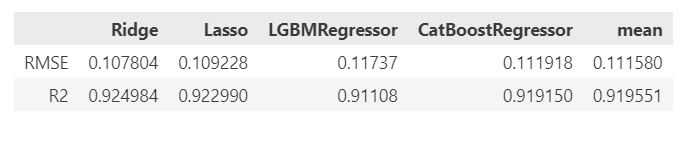

Ridge	Lasso	LGBMRegressor	CatBoostRegressor	mean
RMSE	0.106576	0.106403	0.113151	0.106451	0.108145
R2	0.926683	0.926921	0.917358	0.926855	0.924454


**1. the result improved** Remove line Bath\
 #df_upd['Bath'] = 0.225 * df['BsmtFullBath'] + (-0.0121) * df['BsmtHalfBath'] + 0.636 * df['FullBath'] + 0.343 * df['HalfBath']\
	Ridge	Lasso	LGBMRegressor	CatBoostRegressor	mean\
RMSE	0.107839	0.109357	0.118549	0.110127	**0.111468**\
R2	    0.924935	0.922807	0.909285	0.921716	0.919686\

2. Remove line
    #rem_id = [250, 314, 336, 496, 584, 935, 1299, 1329] **the result got worse**\
	Ridge	Lasso	LGBMRegressor	CatBoostRegressor	mean\
RMSE	0.121717	0.123135	0.145565	0.125641	0.129015\
R2		0.909447	0.907326	0.870488	0.903515	0.897694\


3.  Change filling GarageYrBlt with YearBuilt:**the result got worse**\
 df_upd['GarageYrBlt'] = df_upd['GarageYrBlt'].fillna(df_upd['YearBuilt']) #new_3 \
 	Ridge	Lasso	LGBMRegressor	CatBoostRegressor	mean\
RMSE	0.108765	0.109870	0.119354	0.112227	0.112554\
R2		0.923641	0.922081	0.908048	0.918702	0.918118\

4. Round prediction to nearest 500 **the result got worse**\
pred = np.log1p(np.round(np.exp(pred) / 500) * 500)\
Ridge	Lasso	LGBMRegressor	CatBoostRegressor	mean\
RMSE	0.107754	0.109337	0.117429	0.111843	0.111591\
R2		0.925054	0.922835	0.910991	0.919257	0.919534\

**5. the result improved** Round prediction to nearest 100 \
Ridge	Lasso	LGBMRegressor	CatBoostRegressor	mean\
RMSE	0.107798	0.109229	0.117388	0.111896	**0.111578**\
R2		0.924993	0.922988	0.911053	0.919181	0.919554\

**6. the result improved** Changed order in OrdinalEncoder: \
oec = OrdinalEncoder(categories = [['Po', 'Fa', 'NA', 'TA', 'Gd', 'Ex']]) \
Ridge	Lasso	LGBMRegressor	CatBoostRegressor	mean\
RMSE	0.108610	0.109345	0.117131	0.110971	**0.111514**\
R2		0.923858	0.922824	0.911442	0.920511	0.919659\

**7. the result improved** Added new feature Neighborhoodqual\
df_upd['Neighborhoodqual'] = df_upd.groupby('Neighborhood')['OverallQual'].transform('mean')\
	Ridge	Lasso	LGBMRegressor	CatBoostRegressor	mean\
RMSE	0.105718	0.106429	0.112291	0.106418	**0.107714**\
R2		0.927858	0.926885	0.918610	0.926900	0.925063\

**8. the result improved** Added new feature Totalarea\
df_upd['Totalarea'] = df_upd['GrLivArea'] + df_upd['LotArea']\
	Ridge	Lasso	LGBMRegressor	CatBoostRegressor	mean\
RMSE	0.107839	0.109302	0.115733	0.109190	**0.110516**\
R2		0.924935	0.922885	0.913544	0.923043	0.921102\

8.2 	With normalization Totalarea shows worse results:
Ridge	Lasso	LGBMRegressor	CatBoostRegressor	mean
RMSE	0.107930	0.109299	0.116401	0.111180	0.111202
R2		0.924808	0.922889	0.912543	0.920212	0.920113

9. Added new 'HasGarage', 'HasBasement', 'HasFireplace'. **the result doesnt improve**\
Ridge	Lasso	LGBMRegressor	CatBoostRegressor	mean\
RMSE	0.107306	0.108882	0.11737	0.112784	0.111586\
R2		0.925675	0.923476	0.91108	0.917893	0.919531\

10. Top for now 1+6+7+8  **Kaggle 0.13095 score**\

Ridge	Lasso	LGBMRegressor	CatBoostRegressor	mean\
RMSE	0.106576	0.106403	0.113151	0.106451	0.108145\
R2		0.926683	0.926921	0.917358	0.926855	0.924454\

**11. Made changes in NormalizationTransformer() 

all results in the notebook are the same but **Kaggle 0.12780 score**\

**12.  # Transform MoSold to linear models
        if 'MoSold' in df_upd.columns:
            df_upd['MoSold'] = -np.cos(0.5236 * df_upd['MoSold'])
	Ridge	Lasso	LGBMRegressor	CatBoostRegressor	mean
RMSE	0.106195	0.105947	0.113138	0.104476	0.107439
R2	0.927207	0.927545	0.917377	0.929545	0.925418

In [63]:
# # Stack

# model = LinearRegression()
# model.fit(models_train_pred, y_test)
# fin_pred = model.predict(models_test_pred)

# # create submission file
# subm = pd.DataFrame()
# subm['Id'] = t_id.astype('int')
# subm['SalePrice'] = np.expm1(fin_pred)
# subm.set_index('Id').to_csv('subm_test.csv')

In [69]:
# Stack

model = BayesianRidge()

# model.fit(models_train_pred, y_test)
# fin_pred = model.predict(models_test_pred)

params_br = {'alpha_1': [0.03],
                'alpha_2': [0.01],
                'lambda_1': [0],
                'lambda_2': [0]}


gs_alg = GridSearchCV(model, param_grid = params_br, cv = 5, scoring = 'neg_mean_squared_error', n_jobs=-1)

gs_alg.fit(models_train_pred, y_test)
print(gs_alg.best_estimator_)

fin_pred = gs_alg.predict(models_test_pred)

# create submission file
subm = pd.DataFrame()
subm['Id'] = t_id.astype('int')
subm['SalePrice'] = np.expm1(fin_pred)
subm.set_index('Id').to_csv('submission_test_br.csv')

BayesianRidge(alpha_1=0.03, alpha_2=0.01, lambda_1=0, lambda_2=0)
